# Computer Vision Masterclass - Style Transfer

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.9.2'

## Loading the pre-trained convolutional neural network (VGG19)


In [2]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 5s 0us/step


In [3]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
len(network.layers)

22

## Loading and pre-processing the images

### Content image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
content_image = tf.keras.preprocessing.image.load_img('/content/robert.webp')

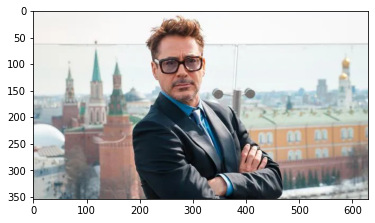

In [7]:
plt.imshow(content_image);

In [8]:
type(content_image)

PIL.WebPImagePlugin.WebPImageFile

In [9]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [10]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (354, 630, 3), 0.0, 255.0)

In [11]:
content_image = content_image / 255

In [12]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [13]:
content_image

array([[[0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        ...,
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ]],

       [[0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        ...,
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ]],

       [[0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        [0.9529412 , 0.94509804, 0.9372549 ],
        ...,
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ],
        [0.96862745, 0.9647059 , 0.9764706 ]],

       ...,

       [[0.7254902 , 0.7490196 , 0.73333335],
        [0.7254902 , 0.7490196 , 0.73333335],
        [0.7254902 , 0

In [14]:
content_image = content_image[tf.newaxis, :]

In [15]:
content_image.shape

(1, 354, 630, 3)

### Style image

In [16]:
style_image = tf.keras.preprocessing.image.load_img('/content/maxresdefault.jpg')

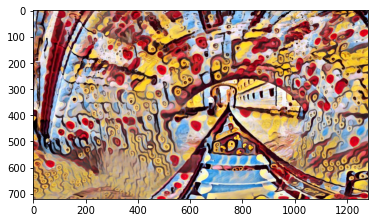

In [17]:
plt.imshow(style_image);

In [18]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 720, 1280, 3)

In [21]:
style_image = tf.keras.preprocessing.image.load_img('/content/back.jpg')

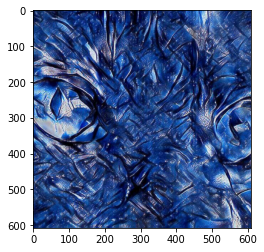

In [22]:
plt.imshow(style_image);

In [23]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 608, 608, 3)

## Building the neural network

In [24]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [25]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [26]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [27]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [28]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [29]:
style_extractor = vgg_layers(style_layers)

In [30]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [31]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [32]:
style_outputs = style_extractor(style_image)

In [33]:
len(style_outputs)

5

In [34]:
style_outputs[1]

<tf.Tensor: shape=(1, 304, 304, 128), dtype=float32, numpy=
array([[[[ 0.        ,  0.        ,  0.        , ...,  4.7118254 ,
           0.        ,  8.059209  ],
         [ 0.        ,  0.        ,  0.        , ...,  2.4473348 ,
           0.        ,  1.6130788 ],
         [ 0.        ,  0.        ,  0.        , ...,  3.5632896 ,
           0.        ,  2.0537739 ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  5.1449385 ,
           0.        ,  0.7583658 ],
         [ 0.        ,  0.        ,  0.17661545, ...,  4.5720577 ,
           0.        ,  0.8646664 ],
         [ 0.        ,  0.        ,  2.9633985 , ...,  7.614677  ,
           0.89508516,  0.        ]],

        [[ 0.        ,  1.4351747 ,  0.        , ...,  4.1020074 ,
           0.        , 10.118077  ],
         [ 0.        ,  2.2816696 ,  0.        , ...,  3.0505114 ,
           1.4164345 ,  0.994528  ],
         [ 0.        ,  1.9849044 ,  0.        , ...,  3.8459864 ,
           1.4578724 ,  2

In [35]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 608, 608, 64]),
 TensorShape([1, 304, 304, 128]),
 TensorShape([1, 152, 152, 256]),
 TensorShape([1, 76, 76, 512]),
 TensorShape([1, 38, 38, 512]))

In [36]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [37]:
style_outputs[0]

<tf.Tensor: shape=(1, 608, 608, 64), dtype=float32, numpy=
array([[[[0.29915303, 0.        , 0.01927156, ..., 0.92252153,
          0.5314396 , 0.44090146],
         [0.43591666, 0.        , 0.07276228, ..., 0.8297334 ,
          0.80449104, 0.71115124],
         [0.3804448 , 0.        , 0.04472592, ..., 0.8295407 ,
          0.75633895, 0.63537717],
         ...,
         [0.3055721 , 0.        , 0.08399478, ..., 0.75265527,
          0.8554154 , 0.7352125 ],
         [0.16227037, 0.        , 0.05742712, ..., 0.73467   ,
          0.77029824, 0.62618625],
         [0.71920586, 0.04762615, 0.2173782 , ..., 0.88647497,
          1.1429139 , 1.0867472 ]],

        [[0.561213  , 0.        , 0.        , ..., 0.82529557,
          0.21037602, 0.24474184],
         [0.8199403 , 0.        , 0.        , ..., 0.6916337 ,
          0.4315221 , 0.49087423],
         [0.66515875, 0.        , 0.        , ..., 0.6751442 ,
          0.44393742, 0.4586257 ],
         ...,
         [0.7301786 , 0.     

In [38]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6563572 , 0.0264112 , 0.08580573, ..., 0.25022724,
         0.3833401 , 0.4771006 ],
        [0.0264112 , 0.00759755, 0.01134774, ..., 0.00137139,
         0.02025195, 0.02527844],
        [0.08580573, 0.01134774, 0.0257427 , ..., 0.01080501,
         0.06446483, 0.07968204],
        ...,
        [0.25022724, 0.00137139, 0.01080501, ..., 0.19610676,
         0.16542488, 0.17936529],
        [0.3833401 , 0.02025195, 0.06446483, ..., 0.16542488,
         0.31061545, 0.34770867],
        [0.4771006 , 0.02527844, 0.07968204, ..., 0.17936529,
         0.34770867, 0.40845966]]], dtype=float32)>

In [39]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [40]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [41]:
extractor = StyleContentModel(style_layers, content_layers)

In [42]:
results = extractor(content_image)

In [43]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 44, 78, 512), dtype=float32, numpy=
  array([[[[0.00000000e+00, 0.00000000e+00, 4.70064392e+01, ...,
            0.00000000e+00, 3.08472656e+02, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 2.10458008e+02, ...,
            0.00000000e+00, 2.65998749e+02, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 2.69228577e+02, ...,
            0.00000000e+00, 4.93493835e+02, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 2.30990036e+02, ...,
            0.00000000e+00, 2.22457794e+02, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 6.60456482e+02, ...,
            0.00000000e+00, 1.93261459e+02, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 5.72699585e+02, ...,
            5.92518997e+01, 3.67157623e+02, 0.00000000e+00]],
  
          [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            5.81721191e+02, 1.27816727e+02, 0.00000000e+00],
           

In [44]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [45]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [46]:
len(style_targets), len(content_targets)

(5, 1)

In [47]:
new_image = tf.Variable(content_image)

In [48]:
content_weight = 1
style_weight = 100

In [49]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training

In [50]:
expected_output = np.array([10000, 15000])
predictions = np.array([8000, 15900])

In [51]:
np.sum(abs(expected_output - predictions)) / 2

1450.0

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [53]:
mean_absolute_error(expected_output, predictions)

1450.0

In [54]:
mean_squared_error(expected_output, predictions)

2405000.0

In [55]:
2 ** 3, 2 * 2 * 2

(8, 8)

In [56]:
10 ** 2, 10 * 10

(100, 100)

In [57]:
((expected_output - predictions) ** 2).mean()

2405000.0

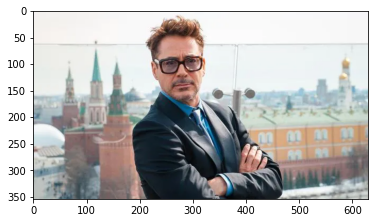

In [58]:
plt.imshow(tf.squeeze(content_image, axis = 0));

Epoch 500 | content loss: 730076.1875 | style loss: 302986144.0 | total loss 6060452864.0


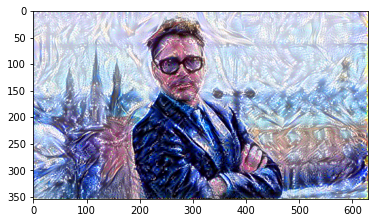

Epoch 1000 | content loss: 750238.5625 | style loss: 172929216.0 | total loss 3459334400.0


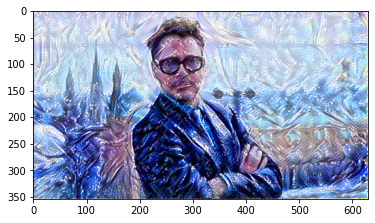

Epoch 1500 | content loss: 759593.75 | style loss: 128555760.0 | total loss 2571874560.0


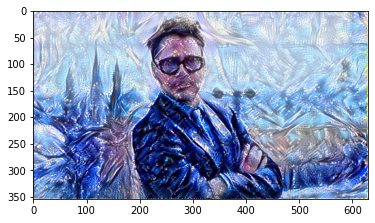

Epoch 2000 | content loss: 766328.1875 | style loss: 103961472.0 | total loss 2079995904.0


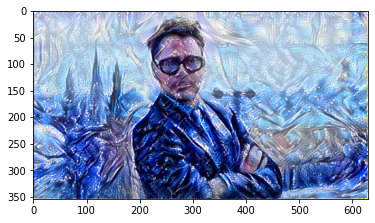

Epoch 2500 | content loss: 773324.0625 | style loss: 92947320.0 | total loss 1859719808.0


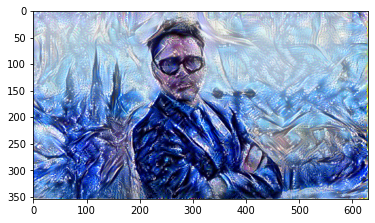

Epoch 3000 | content loss: 780940.8125 | style loss: 94144520.0 | total loss 1883671424.0


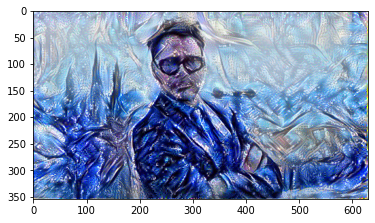

In [59]:
epochs = 3000
print_every = 500

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.show()

## Visualizing the results

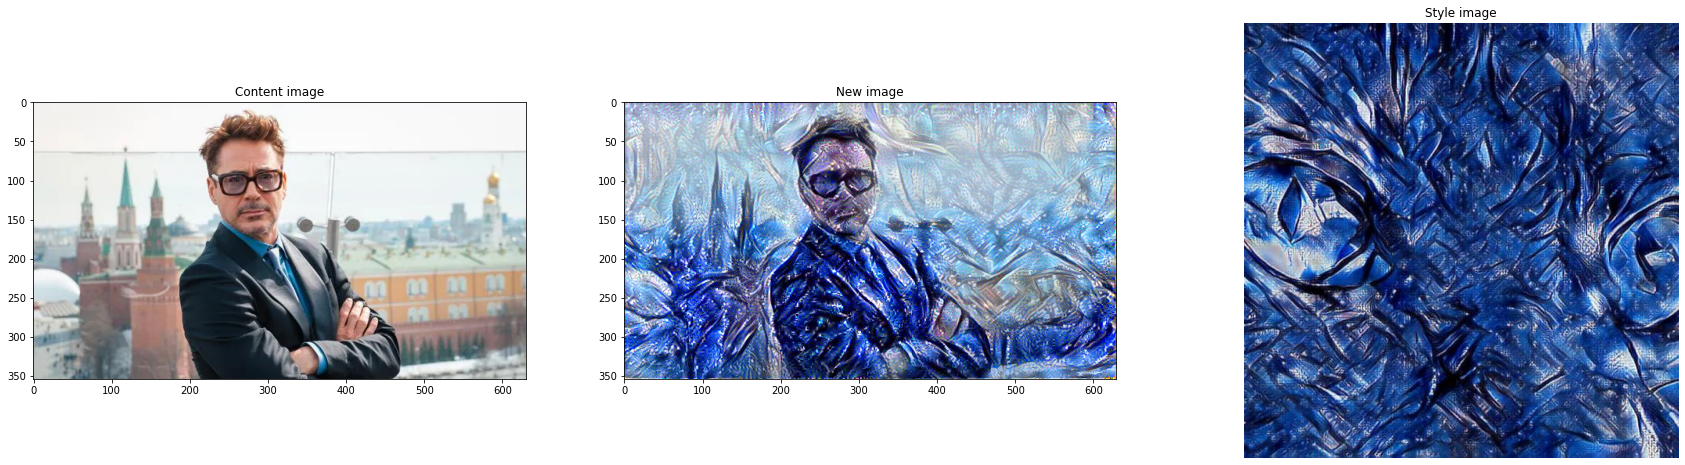

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style image')
plt.axis('off');